In [117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import convolve2d

def gradient(ar):
    grad_i, grad_j = np.gradient(ar)
    return np.array([[(grad_i[i, j], grad_j[i, j]) for j in range(grad_i.shape[1])] for i in range(grad_j.shape[0])])

def get_max_dict(dict, value=False):
    if value: # return key and value
        return max(dict.items(), key=lambda k: k[1])
    else: # return only key
        return max(dict,key=dict.get)
    
def orthogonal_vector(v):
    return np.array([-v[1], v[0]])


In [118]:
class PatchedImage():
    def __init__(self, filename, size):
        self.img = np.array(plt.imread(filename)).astype(float)
        self.height = self.img.shape[0]
        self.width = self.img.shape[1]
        self.size = size
        self.zone = self.set_zone() # Tout le patch doit etre dans la zone ?  #0 = target region, 1 = frontière, 2 = source region
        self.working_patch = (-1,-1)
        self.masque = None # de cette forme [(0,0),(0,0)]
        self.gradient = np.zeros((2,self.height,self.width))

        self.confidence = np.ones(self.img.shape)
        self.data = np.zeros(self.img.shape)
        self.priority = np.zeros(self.img.shape)
    
    def periodic_boundary(self, start_row, end_row, start_col, end_col):
        row_indices = np.arange(start_row, end_row) % self.height
        col_indices = np.arange(start_col, end_col) % self.width
        return self.img[np.ix_(row_indices, col_indices)]

    def patch_boundaries(self,coord):
        k,l = coord
        return k-self.size,k+self.size+1,l-self.size,l+self.size+1
    
    def set_zone(self):
        return np.ones(self.img.shape)*2 #tout est source au debut
    
    def set_working_patch(self,coord):
        self.working_patch = coord

    def outlines_patch(self,coord):
        k,l = coord
        img = self.img[k-self.size:k+self.size+1,l-self.size:l+self.size+1]
        outlines = np.array([img[0,:],img[-1,:],img[:,0],img[:,-1]])
        return np.concatenate(outlines)

    def set_masque(self,c1,c2):
        self.masque = [c1,c2]
        self.img[c1[0]:c2[0]+1,c1[1]:c2[1]+1] = np.nan
        self.zone[c1[0]:c2[0]+1,c1[1]:c2[1]+1] = 0
        self.zone[c1[0]-1,c1[1]-1:c2[1]+1] = 1
        self.zone[c2[0]+1,c1[1]-1:c2[1]+1] = 1
        self.zone[c1[0]-1:c2[0]+1,c1[1]-1] = 1
        self.zone[c1[0]-1:c2[0]+1,c2[1]+1] = 1
    
    def set_priorities(self): #tres tres long pour le moment (a optimiser)
        if self.working_patch == (-1, -1):
            for i in range(self.size,self.height-self.size): #+1 ?
                for j in range(self.size,self.width-self.size): #+1 ?
                    if self.zone[i,j] == 1:
                        conf = self.set_confidence_patch((i,j))
                        dat = self.set_data_patch((i,j))
                        self.priority[i,j] = conf*dat
        else:
            k,l = self.working_patch
            conf = self.set_confidence_patch((k,l))
            dat = self.set_data_patch((k,l))
            self.priority[k,l] = conf*dat

    def set_confidence_patch(self,coord):
        k,l = coord
        somme = 0
        for i in range(k-self.size,k+self.size+1):
            for j in range(l-self.size,l+self.size+1):
                if self.zone[i,j] == 2:
                    somme += self.confidence[i,j]
        res = somme/(self.size*2+1)**2
        self.confidence[coord] = res
        return res
    
    def mean_valid_gradient(self, i, j,):
        #Compute the mean gradients of the valid (non-NaN) neighbors around a given point (i, j) in a 2D arrayfor both x and y directions.
        grad_y, grad_x = self.gradient
        
        valid_gradients_y = []
        valid_gradients_x = []

        # Check the neighbors' gradients; considering the Moore neighborhood (8 surrounding cells)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if di == 0 and dj == 0:
                    continue  # Skip the center point itself
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    # Append valid (non-NaN) gradients from each dimension
                    if not np.isnan(grad_y[ni, nj]):
                        valid_gradients_y.append(grad_y[ni, nj])
                    if not np.isnan(grad_x[ni, nj]):
                        valid_gradients_x.append(grad_x[ni, nj])

        # Calculate the mean of valid gradients for each axis
        mean_gradient_y = np.mean(valid_gradients_y)
        mean_gradient_x = np.mean(valid_gradients_x)

        return (mean_gradient_y, mean_gradient_x)

    def set_gradient_patch(self, coord):
        a,b,c,d = self.patch_boundaries(coord)
        im_patch = self.periodic_boundary(a-1,b+1,c-1,d+1)
        xgrad, ygrad = np.gradient(im_patch)
        self.gradient[0][a:b,c:d] = xgrad[1:b-a+1,1:d-c+1]
        self.gradient[1][a:b,c:d] = ygrad[1:b-a+1,1:d-c+1]

        for i in range(a,b):
            for j in range(c,d):
                if self.zone[i,j]==1:
                    xgrad, ygrad = self.mean_valid_gradient(i, j)
                    self.gradient[0][i,j] = xgrad
                    self.gradient[1][i,j] = ygrad

    def compute_normal(self, coord):
        i,j = coord
        if self.zone[i,j] != 1:
            raise ValueError('trying to calculate normal vector not in frontier')
        
        border_neighbors = []
        target_neighbors = (-1,-1)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if di == 0 and dj == 0:
                    continue  # Skip the center point itself
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    if self.zone[ni,nj] != 1:
                        border_neighbors.append((ni, nj))
                    elif self.zone[ni,nj] == 0:
                        target_neighbors = (ni,nj)

        border_neighbors=sorted(border_neighbors)
        a,b,c,d = border_neighbors[0][0],border_neighbors[0][1],border_neighbors[-1][0],border_neighbors[-1][1]
        x,y = target_neighbors

        tengeante_x,tengeante_y = a-c,b-d

        if y - ((d-b)/(c-a)*(x-a)+b) > 0:
            return (-tengeante_y,tengeante_x)
        else:
            return (tengeante_y,-tengeante_x)

    def set_data_patch(self,coord):
        k,l = coord
        self.set_gradient_patch(coord)
        a,b,c,d = self.patch_boundaries(coord)
        for i in range(a,b):
            for j in range(c,d):
                if self.zone[i,j] != 0:
                    grad_ij = (self.gradient[0][i,j],self.gradient[1][i,j])
                    normal_ij = self.compute_normal(coord)
                    self.data[i,j] = np.dot(orthogonal_vector(grad_ij),normal_ij)/255
        return self.data[k,l]


    def show_patch(self,coord = None):
        if coord == None:
            coord = self.working_patch

        k,l = coord
        img = self.img[k-self.size:k+self.size+1,l-self.size:l+self.size+1]
        plt.imshow(img, cmap='gray')
        plt.title(f"Priority : {self.priority[k,l]:.3f}")
        plt.show()

    def show_img(self):
        fig, ax = plt.subplots()
        ax.imshow(self.img, cmap='gray')
        if self.masque != None:
            x1,y1 = self.masque[0]
            x2,y2 = self.masque[1]
            square = patches.Rectangle((y1,x1),y2-y1,x2-x1,linewidth=1,edgecolor='r',facecolor='r')
            ax.add_patch(square)
            #ax.plot([self.masque[0][1],self.masque[1][1],self.masque[1][1],self.masque[0][1],self.masque[0][1]],[self.masque[0][0],self.masque[0][0],self.masque[1][0],self.masque[1][0],self.masque[0][0]],color=(0,1,0))
        plt.show()

    def show_patch_in_img(self, coord = None):
        if coord == None:
            coord = self.working_patch
        k,l = coord
        contours = self.outlines_patch(coord)
        plt.imshow(self.img, cmap='gray')
        plt.plot([l-self.size,l+self.size,l+self.size,l-self.size,l-self.size],[k-self.size,k-self.size,k+self.size,k+self.size,k-self.size],color=(0,1,0))

In [119]:
# Question
# Frontiere fine ou large ? overlap des patchs avec la zone cible
# Calcul du gradient ? Approximation lineaire sur la frontiere ?
# Idem pour le vecteur normal
# Collage des patchs, ecrasement des pixels de la frontiere ou juste sur la target zone

# gradient discret ? methode de calcul au bord et quelle "portée"
# comment stocker les priorities pour optimiser la vitesse de l'algorithme

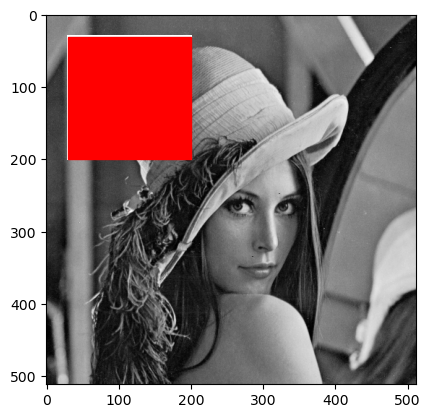

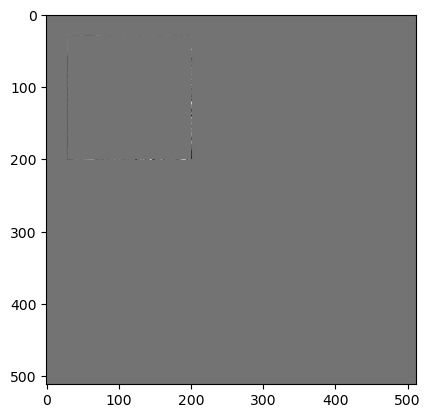

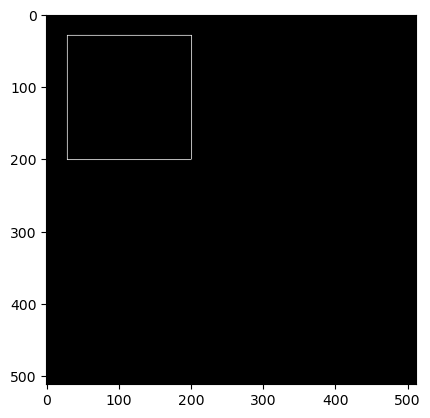

In [122]:
imgp = PatchedImage("images/lena.tif",4)
imgp.set_masque((30,30),(200,200))
imgp.set_priorities()


imgp.show_img()
plt.imshow(imgp.priority, cmap='gray')
plt.show()
plt.imshow(imgp.priority != 0, cmap='gray')
plt.show()
